In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown as md

# from natural_cycles_assignment.import_data import load_and_clean_nc_data

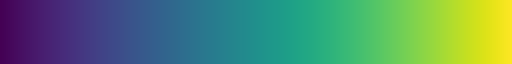

In [3]:
# Set up plotting style
plt.style.use("seaborn-v0_8")
sns.color_palette("viridis", as_cmap=True)

# Load data

In [4]:
import pandas as pd

df = pd.read_csv("../data/external/ncdatachallenge-2021-v1.csv", index_col=0)

print(df.shape)
df.head()

(1995, 13)


,bmi,age,country,been_pregnant_before,education,sleeping_pattern,n_cycles_trying,outcome,dedication,average_cycle_length,cycle_length_std,regular_cycle,intercourse_frequency
0,22.942130,31,SE,"No, never",University,Wake same every workday,1,pregnant,0.640000,25.588235,2.526332,True,0.200000
1,19.886054,34,NaN,NaN,University,NaN,7,pregnant,0.009569,30.875000,3.522884,True,0.052632
2,29.323049,41,SE,"No, never",University,Several times during the night,4,not_pregnant,0.298246,27.666667,2.503331,True,0.149123
3,24.386526,27,SE,"No, never",High school,Wake same every workday,2,pregnant,0.895833,24.250000,3.453776,True,0.145833
4,29.299971,29,SE,"No, never",Trade/technical/vocational training,Wake same every day,2,pregnant,0.666667,25.466667,0.990430,True,0.254902


## Data completeness

In [5]:
# Count NaN's in each column
print("NaN count:\n", df.isna().sum())

NaN count:
 bmi                        0
age                        0
country                  113
been_pregnant_before     317
education                391
sleeping_pattern         499
n_cycles_trying            0
outcome                    0
dedication                 0
average_cycle_length       6
cycle_length_std          25
regular_cycle              6
intercourse_frequency      0
dtype: int64


Comments of Jeroen:

Only country, been_pregnant_before, education, sleeping pattern, cycle_length_sd and regular_cycle contain NaN values

When analysing which factors involve pregnancy it might be necessary to drop these samples.

In [6]:
md(f"{df.dropna().shape[0]}/{df.shape[0]} samples do not contain NaN values.")

1185/1995 samples do not contain NaN values.

## Outlier + data range inspection

In [7]:
def safe_min_max(series: pd.Series) -> pd.Series:
    """For each numeric column, return the min and max values. If the column is not numeric, return None for both min and max."""
    try:
        return pd.Series({"min": series.min(), "max": series.max()})
    except TypeError:
        return pd.Series({"min": None, "max": None})


min_max_summary = df.apply(safe_min_max)
print(min_max_summary.T)  # transpose for better readability

                                min         max
bmi                             0.0   50.611299
age                              19          44
country                        None        None
been_pregnant_before           None        None
education                      None        None
sleeping_pattern               None        None
n_cycles_trying                   1          26
outcome                not_pregnant    pregnant
dedication                      0.0    1.347826
average_cycle_length           19.5       145.5
cycle_length_std                0.0  168.998521
regular_cycle                 False        True
intercourse_frequency           0.0    0.793103


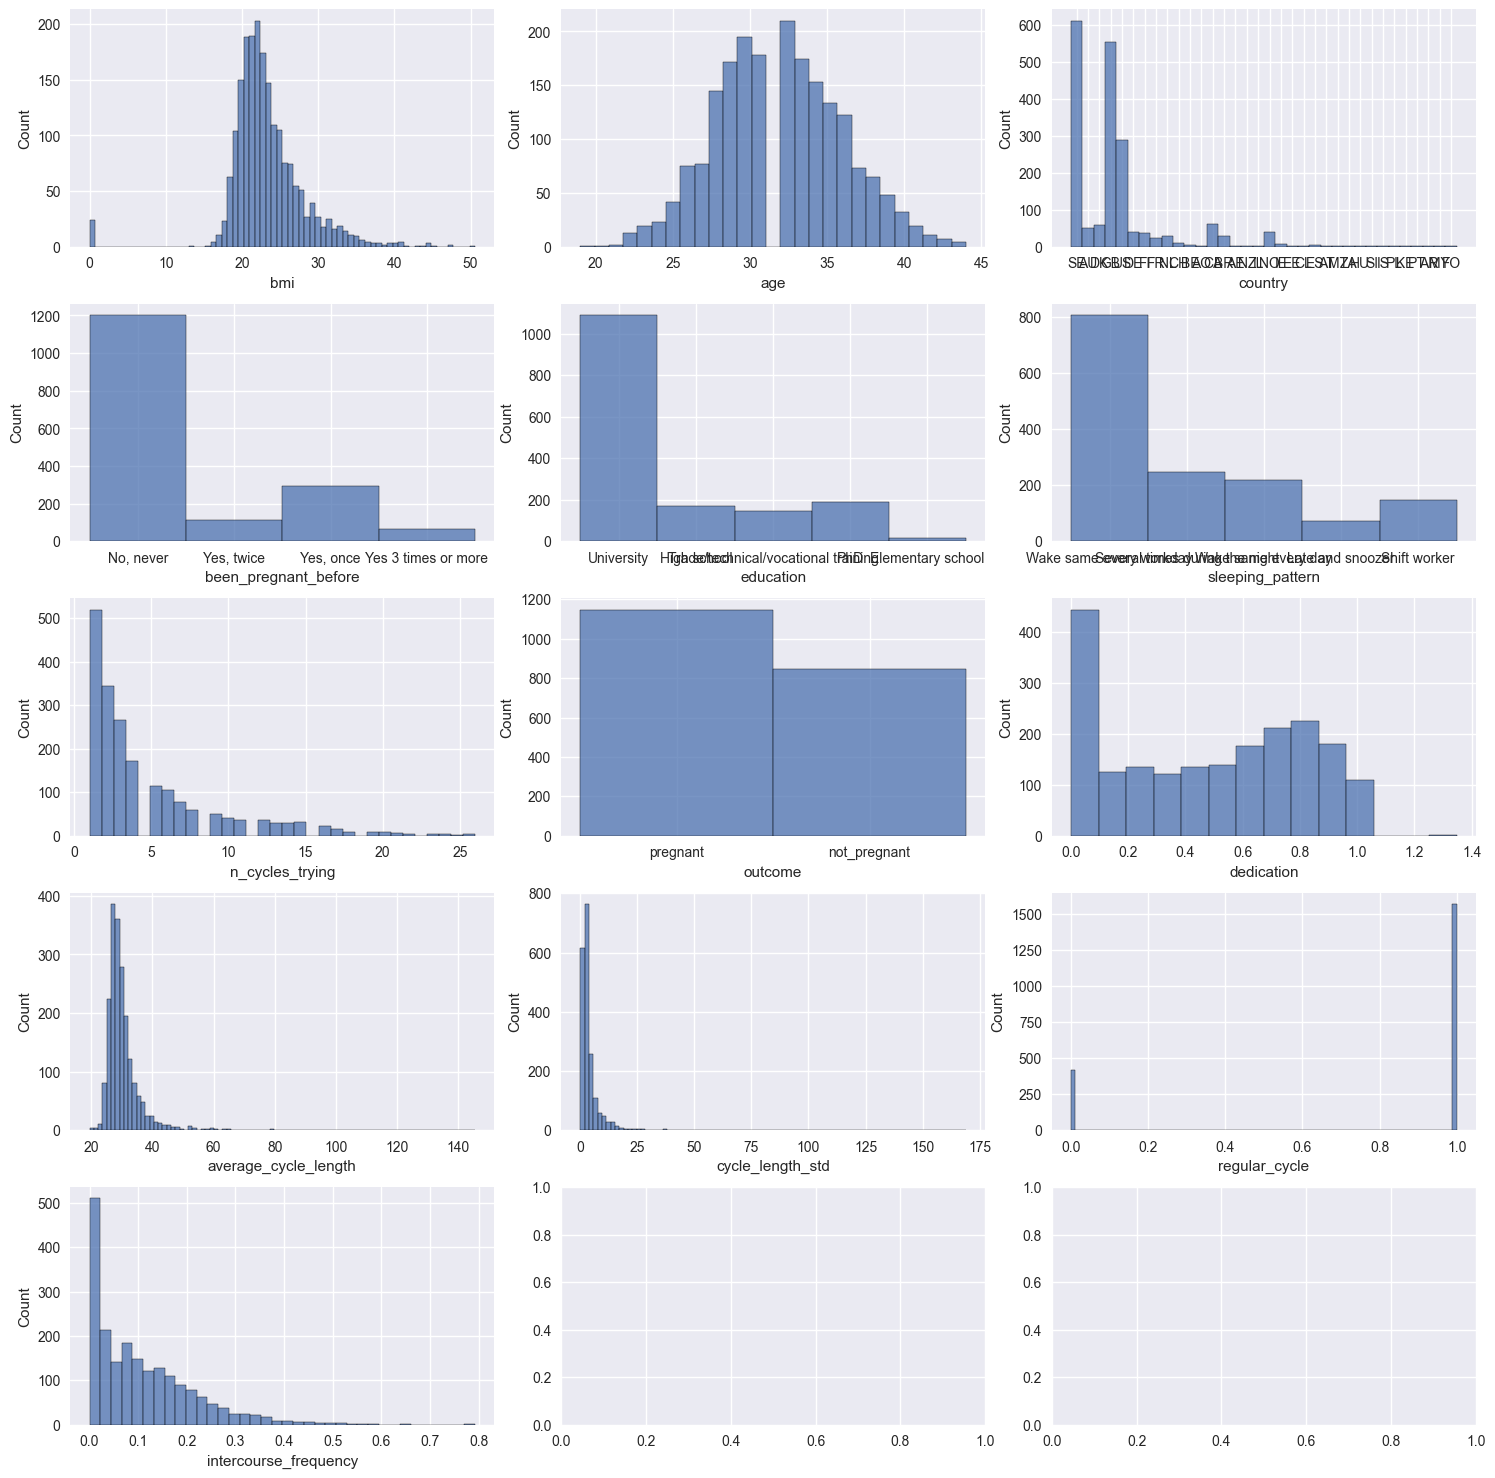

In [ ]:
# Plot histograms for each df column
fig, axes = plt.subplots(int(np.ceil(df.shape[1] / 3)), 3, figsize=(15, 15))
fig.tight_layout(pad=2)  # add padding between subplots to avoid overlapping text

for i, column in enumerate(df.columns):
    sns.histplot(df, x=column, ax=axes[i // 3, i % 3])
    # rotate x-axis labels
    # axes[i//3, i%3].tick_params(axis="x", rotation=30)

plt.show()

Comments Jeroen:

Most variables do not show any noteworthy outliers.

BMW ranges from 13 to 50, which are both quite extreme values: BMI 13 being extremely underweight and 50 very high. Both are not impossible though, so I am hesitant of throwing these out. 